# Modelling the same patient population attending all hospitals

Aim:

* To predict the thrombolysis rate at each hospital if the same patient population (based on the national average patient characteristics) attend each hospital.

Patient population distributions are set to have the national average of:

* Arrival within 4 hours of stroke onset
* Proportion aged 80+
* Onset to arrival mean and standard deviation

The proportion of arrivals eligible for thrombolysis is set to the predicted 10k cohort rate for each hospital (adjusted to give thrombolysis use in those patients scanned within 4 hours of stroke onset).

The simulation model passes through 100 x 1k patient cohorts through each hospital model.

## Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

## Load data

In [2]:
# Scenario results
results = pd.read_csv('./output/scenario_results.csv')
# Pathway performance paramters used in scenarios
performance_base = pd.read_csv('./output/performance_base.csv')
performance_same_patients = \
    pd.read_csv('./output/same_patient_characteristics.csv')

In [3]:
performance_base

,stroke_team,thrombolysis_rate,admissions,80_plus,onset_known,known_arrival_within_4hrs,onset_arrival_mins_mu,onset_arrival_mins_sigma,scan_within_4_hrs,arrival_scan_arrival_mins_mu,arrival_scan_arrival_mins_sigma,onset_scan_4_hrs,eligable,scan_needle_mins_mu,scan_needle_mins_sigma
0,AGNOF1041H,0.154839,671.666667,0.425459,0.635236,0.681250,4.576874,0.557598,0.965596,1.665700,1.497966,0.935867,0.388325,3.669602,0.664462
1,AKCGO9726K,0.158892,1143.333333,0.395658,0.970845,0.428829,4.625486,0.597451,0.955882,2.834183,0.999719,0.908425,0.419355,2.904479,0.874818
2,AOBTM3098N,0.085885,500.666667,0.485470,0.619174,0.629032,4.603918,0.584882,0.935043,3.471419,1.254744,0.846435,0.267819,3.694918,0.518929
3,APXEE8191H,0.098634,439.333333,0.515679,0.716237,0.608051,4.590357,0.496452,0.966899,3.312930,0.714465,0.904505,0.258964,3.585094,0.751204
4,ATDID5461S,0.090689,275.666667,0.533546,0.573156,0.660338,4.427826,0.591373,0.878594,4.125690,0.549301,0.865455,0.315126,3.497262,0.608126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,YPKYH1768F,0.105193,250.333333,0.321767,0.585885,0.720455,4.436404,0.569248,0.952681,3.779215,0.872809,0.844371,0.305882,3.982100,0.683223
128,YQMZV4284N,0.104186,358.333333,0.508511,0.945116,0.462598,4.664536,0.494740,0.948936,3.574735,0.912298,0.798206,0.308989,3.285165,0.463749
129,ZBVSO0975W,0.081602,449.333333,0.442130,0.465134,0.688995,4.562051,0.510524,0.972222,2.860226,0.990966,0.930952,0.273657,3.606046,0.575788
130,ZHCLE1578P,0.112647,796.000000,0.484694,0.733668,0.671233,4.606557,0.546648,0.949830,3.306916,0.842940,0.892569,0.262788,3.276043,0.795401


## Collate key results

Collate key results together in a DataFrame.

In [4]:
# Add admission numbers to results
admissions = performance_base[['stroke_team', 'admissions']]
results = results.merge(
    admissions, how='left', left_on='stroke_team', right_on='stroke_team')

# Calculate numbers thrombolysed
results['thrombolysed'] = \
    results['admissions'] * results['Percent_Thrombolysis_(mean)'] / 100

# Calculate additional good outcomes
results['add_good_outcomes'] = (results['admissions'] * 
    results['Additional_good_outcomes_per_1000_patients_(mean)'] / 1000)

# Get key results
key_results = pd.DataFrame()
key_results['stroke_team'] = results['stroke_team']
key_results['scenario'] = results['scenario']
key_results['admissions'] = results['admissions']
key_results['thrombolysis_rate'] = results['Percent_Thrombolysis_(mean)']
key_results['additional_good_outcomes_per_1000_patients'] = \
    results['Additional_good_outcomes_per_1000_patients_(mean)']
key_results['patients_receiving_thrombolysis'] = results['thrombolysed']
key_results['add_good_outcomes'] = results['add_good_outcomes']

In [5]:
key_results

,stroke_team,scenario,admissions,thrombolysis_rate,additional_good_outcomes_per_1000_patients,patients_receiving_thrombolysis,add_good_outcomes
0,AGNOF1041H,base,671.666667,15.20,12.76,102.093333,8.570467
1,AKCGO9726K,base,1143.333333,14.91,13.21,170.471000,15.103433
2,AOBTM3098N,base,500.666667,7.80,5.67,39.052000,2.838780
3,APXEE8191H,base,439.333333,10.40,7.59,45.690667,3.334540
4,ATDID5461S,base,275.666667,9.17,6.28,25.278633,1.731187
...,...,...,...,...,...,...,...
1183,YPKYH1768F,same_patient_characteristics,250.333333,7.47,4.98,18.699900,1.246660
1184,YQMZV4284N,same_patient_characteristics,358.333333,15.92,12.87,57.046667,4.611750
1185,ZBVSO0975W,same_patient_characteristics,449.333333,7.66,6.23,34.418933,2.799347
1186,ZHCLE1578P,same_patient_characteristics,796.000000,10.76,8.78,85.649600,6.988880


## Summary stats

In [6]:
comparison = pd.DataFrame()
comparison['actual'] = key_results[key_results['scenario']=='base']['thrombolysis_rate'].values
comparison['cohort'] = key_results[key_results['scenario']=='same_patient_characteristics']['thrombolysis_rate'].values

comparison.describe().round(2)

,actual,cohort
count,132.00,132.00
mean,11.23,11.08
std,3.37,3.91
min,1.69,2.65
25%,9.24,8.29
50%,10.92,10.96
75%,13.12,12.87
max,24.23,24.93


## Plot results

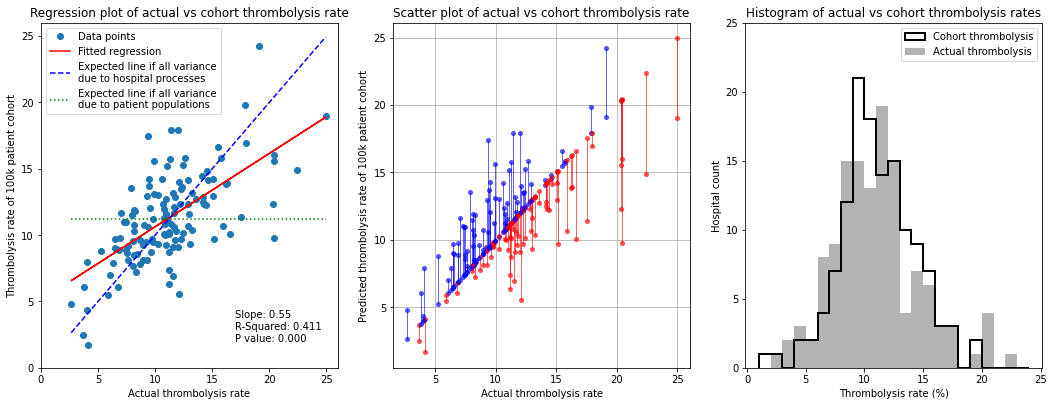

In [8]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(131)
y = key_results[key_results['scenario']=='base']['thrombolysis_rate']
x = key_results[key_results['scenario']=='same_patient_characteristics']['thrombolysis_rate']
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
y_fit=intercept + (x*gradient)
ax1.plot(x, y, 'o', label='Data points')
ax1.plot(x, y_fit, 'r', label='Fitted regression')
ax1.plot([x.min(),x.max()],[x.min(),x.max()], 'b--', 
         label = 'Expected line if all variance\ndue to hospital processes')
mean_thrombolysis = comparison['actual'].mean()
ax1.plot([x.min(),x.max()],[mean_thrombolysis, mean_thrombolysis], 'g:', 
         label = 'Expected line if all variance\ndue to patient populations')

text='Slope: %.2f\nR-Squared: %.3f\nP value: %.3f' %(gradient,r_value**2,p_value)
ax1.set_xlim(0,26)
ax1.set_ylim(0,26)
ax1.text(17,2,text)
ax1.legend()
ax1.set_ylabel('Thrombolysis rate of 100k patient cohort')
ax1.set_xlabel('Actual thrombolysis rate')
ax1.set_title('Regression plot of actual vs cohort thrombolysis rate')

ax2 = fig.add_subplot(132)
zipped = zip(x,y)
for xx, yy in zipped:
    colour = 'red' if xx > yy else 'blue'
    ax2.plot([xx,xx], [xx,yy], 
             color=colour, lw=1, marker='o', alpha=0.6, markersize=4)
ax2.set_ylabel('Predicted thrombolysis rate of 100k patient cohort')
ax2.set_xlabel('Actual thrombolysis rate')
ax2.set_title('Scatter plot of actual vs cohort thrombolysis rate')
ax2.grid()


ax3 = fig.add_subplot(133)
bins = np.arange(1,25)
ax3.hist(y, bins = bins, color='k', linewidth=2,
           label='Cohort thrombolysis', histtype='step')
ax3.hist(x, bins = bins, color='0.7', linewidth=2,
           label='Actual thrombolysis', histtype='stepfilled')
ax3.set_xlabel('Thrombolysis rate (%)')
ax3.set_ylabel('Hospital count')
ax3.set_title('Histogram of actual vs cohort thrombolysis rates')
ax3.set_ylim(0,25)
ax3.legend()

plt.tight_layout(pad=2)
plt.savefig('./output/pathway_cohort.jpg', dpi=300)
plt.show()

## Observations

* In this experiment we fix the patient population, so that all hospitals in the model see the same patients, and pass those patients through each hospital model using that hospital's pathway characteristics and decision model.

* When a standard (national average) patient population is passed through all hospitals the cohort thrombolysis rate at each hospital correlates with the actual thrombolysis use with R-square of 0.41, suggesting in-hospital processes and decision making account for about 40% of observed variance. Similarly, the regression fit between actual and cohort thrombolysis rate has a slope of 0.55, suggesting that 55% of the inter-hospital variance is due to hospital processes - when the patient population is unchanged there is, on average, a 0.55 percentage point difference in predicted cohort population thrombolysis rate for each 1 percentage point change in actual thrombolysis rate.

* As a general guide it seems that about half of the inter-hospital variance in thrombolysis rate is explained by in-hospital process and decisions, and the other half is explained by differences in local populations.

* As should be expected, the mean and distribution of the cohort thrombolysis use per hospital is very similar to the actual mean and distribution of thrombolysis use.

* There is a tendency for lower thrombolysing units to do better with a standard cohort, and those with higher thrombolysis rates to do worse. So there is a general observation that hospitals with high thrombolysis use do so partly because they have a more thrombolysable population, and vice versa.